# Machine Learning Prediction

Objetivos do projeto:
- Construir um modelo para predição de cancelamento de uma reserva.

## Data Acquisition

Vamos importar as bibliotecas necessárias para essa parte da análise:

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD

from sklearn import metrics 
from sklearn.metrics import confusion_matrix

import pickle
import numpy as np

Vamos carregar o dataset e olhar para as primeiras linhas com o método `head`:

In [4]:
df = pd.read_csv("hotel_bookings.csv")

## Preprocessing

Vamos dar uma olhada nos atributos com valores nulos.

In [5]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Como os atributos mais significativos (como o `is_canceled`) não contém valores nulos, não precisamos excluir nenhum dado da base, apenas preenchemos os valores nulos:

In [6]:
# preenchimento dos valores NaN com 0
df['children'] = df['children'].fillna(0)

# preenchimento dos valores NaN com a moda
df['country'].fillna(df['country'].mode()[0], inplace=True)
df['agent'].fillna(df['agent'].mode()[0], inplace=True)
df['company'].fillna(df['company'].mode()[0], inplace=True)

Vamos dar uma olhada nos atributos do dataset:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

Iremos manter sem alterações os atributos:
`is_canceled`, `lead_time`, `arrival_date_year`, `arrival_date_week_number`,`arrival_date_day_of_month`, `adults`,
`stays_in_weekend_nights`, `stays_in_week_nights`,`is_repeated_guest`, `booking_changes`,`days_in_waiting_list`, `adr`, `required_car_parking_spaces`, `total_of_special_requests`, `agent`, `company`.

1. Iremos substituir os seguintes atributos: 
*   `children` e `babies` -> `kids` 
*   `previous_cancellations` e `previous_bookings_not_canceled` -> `total_bookings`
*   `reserved_room_type`, `assigned_room_type` -> `same_room`

2. Iremos remover os seguintes atributos:
`meal`, `reservation_status_date`, `reservation_status`, `children`,`babies`,  `reserved_room_type`, `assigned_room_type`  

3. E, por fim, temos alguns atributos com valores categóricos. Iremos converter os seguintes atributos para inteiro:
`hotel`, `country`, `market_segment`, `distribution_channel`, `deposit_type`, `customer_type`, `arrival_date_month`



**1. Substituição dos atributos:**

In [8]:
# Agrupamento das colunas children e babies na coluna children
df['has_children'] = df['children']+df['babies']
df['has_children'] = df['has_children'].apply(lambda x: '1' if x >= 1 else '0')

# Agrupamento das colunas previous_cancellations e previous_bookings_not_canceled na coluna total_bookings
df['total_bookings'] = df['previous_cancellations']+df['previous_bookings_not_canceled']

# Agrupamento das colunas assigned_room_type e reserved_room_type em uma nova coluna same_room
def isSameRoom(row):
    if row['assigned_room_type'] == row['reserved_room_type']:
        return 1
    else:
        return 0

df['same_room'] = df.apply(isSameRoom, axis=1)

**2. Remoção dos atributos:**

In [9]:
df.drop(['meal', 'children', 
         'babies', 'assigned_room_type', 'reserved_room_type',
         'reservation_status', 'reservation_status_date'], axis=1, inplace=True)

**3. Conversão dos atributos:**

Vamos converter os meses para valores inteiros:

In [10]:
monthMap = {'January':1, 'February':2, 'March':3, 
             'April':4, 'May':5, 'June':6, 
             'July':7, 'August':8, 'September':9, 
             'October':10, 'November':11, 'December':12}

df['arrival_date_month'] = df['arrival_date_month'].replace(monthMap)

Vamos conveter também as outras colunas com valores categóricos:

In [11]:
le = preprocessing.LabelEncoder()
atts = ['hotel', 'country', 'market_segment', 'distribution_channel', 
        'deposit_type', 'customer_type']

for att in atts:
    df[att] = le.fit_transform(df[att])

## Prediction

Vamos dividir o conjunto de dados 80% para treino e 20% para teste:

In [12]:
y = df['is_canceled']
df.drop(['is_canceled'], axis='columns', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

Como temos um conjunto com atributos muito diversos, a falta de padronização pode enviesar o resultado para variáveis com maior ordem de grandeza em alguns algoritmos. Vamos normalizar nossos dados deixando-os na mesma ordem de grandeza:



In [13]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**Decision Tree:**

Vamos treinar Decision Trees com diferentes valores de `max_depth` e comparar os resultados obtidos:

In [15]:
maxDepth = [3,6,9,12,15,18,21]

accDT   = []
precDT  = []
recDT   = []
f1SDT   = []

for depth in maxDepth:

    # Create Decision Tree classifer object
    clf_dt = tree.DecisionTreeClassifier(criterion="gini", max_depth=depth)

    # Train Decision Tree Classifer
    clf_dt = clf_dt.fit(X_train,y_train)

    # Predict the response for test dataset
    y_pred = clf_dt.predict(X_test)

    #tree.plot_tree(clf_dt)

    accDT.append(metrics.accuracy_score(y_test, y_pred))
    precDT.append(metrics.precision_score(y_test, y_pred))
    recDT.append(metrics.recall_score(y_test, y_pred))
    f1SDT.append(metrics.f1_score(y_test, y_pred))

Comparando os resultados obtidos:

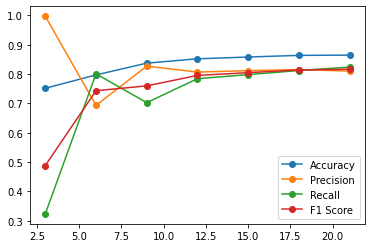

In [21]:
plt.plot(maxDepth, accDT, label='Accuracy', marker='o')
plt.plot(maxDepth, precDT, label='Precision', marker='o')
plt.plot(maxDepth, recDT, label='Recall', marker='o')
plt.plot(maxDepth, f1SDT, label='F1 Score', marker='o')

plt.legend()
plt.show()

**Logistic Regression:**

In [22]:
# Logistic Regression
logreg = LogisticRegression(max_iter=500)
logreg = logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

logAcc  = metrics.accuracy_score(y_test, y_pred)
logPrec = metrics.precision_score(y_test, y_pred)
logRec  = metrics.recall_score(y_test, y_pred)
logF1S  = metrics.f1_score(y_test, y_pred)

print("Accuracy:", logAcc)
print("Precision:", logPrec)
print("Recall:", logRec)
print("F1 score:", logF1S)

print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7890108049250356
Precision: 0.7863972856261567
Recall: 0.582609689213894
F1 score: 0.6693357836702547
Confusion Matrix: 
[[13741  1385]
 [ 3653  5099]]


**Support Vector Machine (SVM):**

In [23]:
# Cria um classificador SVM
clf = svm.SVC(kernel='rbf') 

# Treina o modelo com os dados de treino
clf.fit(X_train, y_train)

# Faz a predição com os dados de teste
y_pred = clf.predict(X_test)
y_pred = y_pred > 0.5 

svmAcc  = metrics.accuracy_score(y_test, y_pred)
svmPrec = metrics.precision_score(y_test, y_pred)
svmRec  = metrics.recall_score(y_test, y_pred)
svmF1S  = metrics.f1_score(y_test, y_pred)

print("Accuracy:", svmAcc)
print("Precision:", svmPrec)
print("Recall:", svmRec)
print("F1 score:", svmF1S)

print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8236451964151101
Precision: 0.8159176290524558
Recall: 0.670018281535649
F1 score: 0.735805257544388
Confusion Matrix: 
[[13803  1323]
 [ 2888  5864]]


**Multi-Layer Perceptron (MLP):**

In [12]:
# create model with one hidden layer and one output layer
model = tf.keras.Sequential([
  layers.Dense(10, 
               activation=tf.nn.relu,
               kernel_initializer=tf.keras.initializers.RandomNormal(mean=0,stddev=1),
               ),
  layers.Dense(1, 
               activation=tf.nn.sigmoid) 
])

# set error function, optimizer and avaliation metric
model.compile(loss='MeanSquaredError', 
              optimizer=SGD(lr=0.01, momentum=0.9), 
              metrics=['accuracy'])


# train the model
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=500,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


2985/2985 [==============================] - 7s 2ms/step - loss: 0.1630 - accuracy: 0.7524 - val_loss: 0.1520 - val_accuracy: 0.7701
Epoch 2/500
2985/2985 [==============================] - 6s 2ms/step - loss: 0.1505 - accuracy: 0.7743 - val_loss: 0.1492 - val_accuracy: 0.7743
Epoch 3/500
2985/2985 [==============================] - 6s 2ms/step - loss: 0.1480 - accuracy: 0.7776 - val_loss: 0.1467 - val_accuracy: 0.7774
Epoch 4/500
2985/2985 [==============================] - 5s 2ms/step - loss: 0.1470 - accuracy: 0.7803 - val_loss: 0.1462 - val_accuracy: 0.7800
Epoch 5/500
2985/2985 [==============================] - 6s 2ms/step - loss: 0.1462 - accuracy: 0.7809 - val_loss: 0.1464 - val_accuracy: 0.7771
Epoch 6/500
2985/2985 [==============================] - 5s 2ms/step - loss: 0.1452 - accuracy: 0.7829 - val_loss: 0.1444 - val_accuracy: 0.7819
Epoch 7/500
2985/2985 [==============================] - 6s 2ms/step - loss: 0.1441 - accuracy: 0.7836 - val_loss: 0.1426 - val_accuracy: 0.78

In [14]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5 

mlpAcc  = metrics.accuracy_score(y_test, y_pred)
mlpPrec = metrics.precision_score(y_test, y_pred)
mlpRec  = metrics.recall_score(y_test, y_pred)
mlpF1S  = metrics.f1_score(y_test, y_pred)

print("Accuracy:", mlpAcc)
print("Precision:", mlpPrec)
print("Recall:", mlpRec)
print("F1 score:", mlpF1S)

print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8420303207973867
Precision: 0.8231920199501247
Recall: 0.737159446181331
F1 score: 0.777803958529689
Confusion Matrix: 
[[13504  1418]
 [ 2354  6602]]


Algumas análises podem ser feitas para auxiliar no ajuste dos hiperparâmetros da rede:

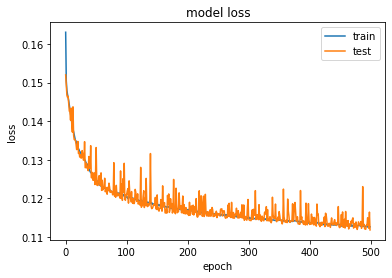

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

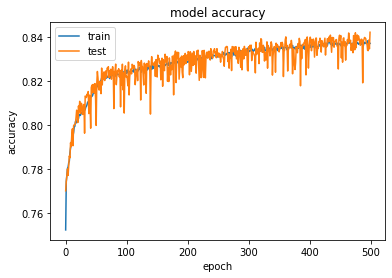

In [17]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Fazendo uma comparação entre os modelos obtidos, ficamos com:

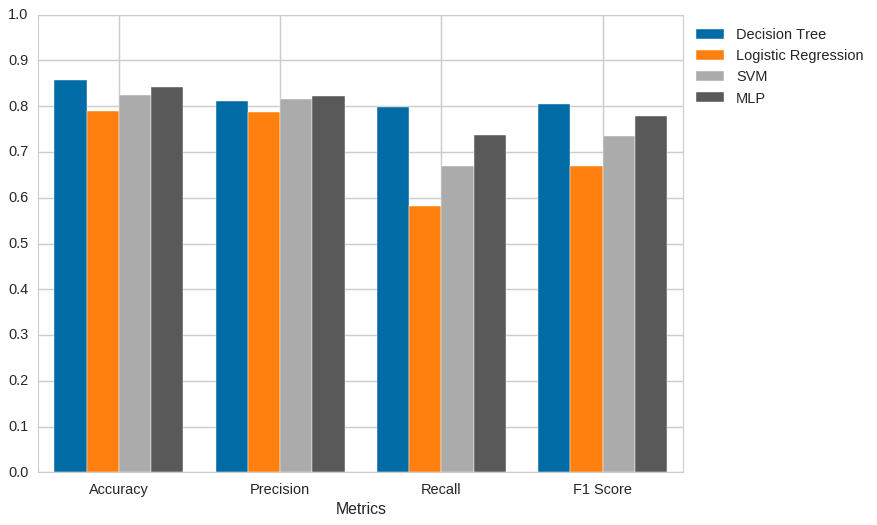

In [50]:
plt.style.use('tableau-colorblind10')

X = ['Accuracy','Precision','Recall','F1 Score']

dt  = [accDT[4], precDT[4], recDT[4], f1SDT[4]]
log = [logAcc, logPrec, logRec, logF1S]
svm = [svmAcc, svmPrec, svmRec, svmF1S]
mlp = [mlpAcc, mlpPrec, mlpRec, mlpF1S]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.3, dt, 0.2, label = 'Decision Tree')
plt.bar(X_axis - 0.1, log, 0.2, label = 'Logistic Regression')
plt.bar(X_axis + 0.1, svm, 0.2, label = 'SVM')
plt.bar(X_axis + 0.3, mlp, 0.2, label = 'MLP')
 
plt.xticks(X_axis, X)
plt.xlabel("Metrics")
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

plt.legend(bbox_to_anchor=(1.3, 1.0))

plt.show()

# Deploy

O melhor modelo obtido foi com a Decision Tree, com `max_depth=15`. Vamos salvar esse modelo em um arquivo:

In [25]:
# Create Decision Tree classifer object
clf_dt = tree.DecisionTreeClassifier(criterion="gini", max_depth=15)

# Train Decision Tree Classifer
clf_dt = clf_dt.fit(X_train,y_train)

# Save model
pickle.dump(clf_dt, open('model.pkl','wb'))